Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [1]:
# # Install a pip package in the current Jupyter kernel 🚨RUN THIS CELL ONCE FOR YOUR ENVIRONMENT
# import sys
# !"{sys.executable}" -m pip install "aerosandbox[full]"
# !"{sys.executable}" -m pip install "gymnasium[all]"
# !"{sys.executable}" -m pip install "stable_baselines3[extra]"
# !"{sys.executable}" -m pip install "tensorboard"

Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [2]:
#Helper
import aerosandbox.numpy as np
def flatten_list(nested_item):
    flattened = []
    
    if isinstance(nested_item, (list, np.ndarray)):
        for item in nested_item:
            flattened.extend(flatten_list(item))
    else:
        flattened.append(nested_item)
    
    return flattened

In [3]:
import aerosandbox as asb
import gymnasium as gym
from gymnasium import spaces
import numpy as np
	
class AeroEnv(gym.Env):

	# construct and save self.airplane from self.xsecs
	def constructAirplane(self):
		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=True,
					xsecs=self.xsecs
				)],
		)
	
	#attempting to constraint reward
	def getReward(self):
		lift = self.aero["L"]
		drag = self.aero["D"]
		reward = lift/drag
		if(drag < 0 or lift < 0):
			reward = -abs(reward)

		if(reward > 120): #likely a ridiculous value
			reward = -(reward - 120)
		
		#final constraints, to prevent insanely negative rewards
		reward = max(reward, -1)
			

		return reward

	# construct and safe self.vlm()
	def runAero(self):
		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			),
			
		)
		self.vlm.run_symmetric = True
		self.aero = self.vlm.run()
		
	# get observations from current self.xsecs
	def get_observation_vector(self):
		obs = []
		for xsec in self.xsecs:
			# xyz_le is a list of three values
			obs.extend(xsec.xyz_le)
			
			# chord and twist are single values
			obs.append(xsec.chord)
			obs.append(xsec.twist)

			# KulfanAirfoil attributes
			# Both upper_weights and lower_weights are numpy arrays
			obs.extend(xsec.airfoil.upper_weights.tolist())
			obs.extend(xsec.airfoil.lower_weights.tolist())

			# leading_edge_weight, N1, and N2 are single values
			obs.append(xsec.airfoil.leading_edge_weight)
			obs.append(xsec.airfoil.N1)
			obs.append(xsec.airfoil.N2)
		# Append aerodynamics output at the end
		# - 'F_g' : an [x, y, z] list of forces in geometry axes [N]
		# - 'F_b' : an [x, y, z] list of forces in body axes [N]
		# - 'F_w' : an [x, y, z] list of forces in wind axes [N]
		# - 'M_g' : an [x, y, z] list of moments about geometry axes [Nm]
		# - 'M_b' : an [x, y, z] list of moments about body axes [Nm]
		# - 'M_w' : an [x, y, z] list of moments about wind axes [Nm]
		# - 'L' : the lift force [N]. Definitionally, this is in wind axes.
		# - 'Y' : the side force [N]. This is in wind axes.
		# - 'D' : the drag force [N]. Definitionally, this is in wind axes.
		# - 'l_b', the rolling moment, in body axes [Nm]. Positive is roll-right.
		# - 'm_b', the pitching moment, in body axes [Nm]. Positive is pitch-up.
		# - 'n_b', the yawing moment, in body axes [Nm]. Positive is nose-right.
		# - 'CL', the lift coefficient [-]. Definitionally, this is in wind axes.
		# - 'CY', the sideforce coefficient [-]. This is in wind axes.
		# - 'CD', the drag coefficient [-]. Definitionally, this is in wind axes.
		# - 'Cl', the rolling coefficient [-], in body axes
		# - 'Cm', the pitching coefficient [-], in body axes
		# - 'Cn', the yawing coefficient [-], in body axes
		drag = self.aero["D"]
		lift = self.aero["L"]
		drag = np.tanh((drag-50)/50)
		lift = np.tanh((lift-50)/50)
		obs.append(lift)
		obs.append(drag)
		return np.array(obs, dtype=np.float32)
	
	def __init__(self, 
			  # === Key Parameters ===
			  episodeSteps,
			  kulfanWeightResolution, 	#How many kulfan weights per XSec? More = more intricate designs. Something like 5-8 should be enough...
			  numChords, 				#How many independently controlled foils along length of wing 

			  # === Initial Values ===
			  initialYSpacing, 			#Initial spacing of the cross sections
			  initialChordLength, 		#Initial length from front to back of each cross section in wing
			  initialUpperKulfan, 		#Upper kulfan weight initial values (controls curvature of top of wing)
			  initialLowerKulfan, 		#Lower Kulfan weight initial values (controls curvature of bottom of wing)
			  initialLEW, 				#Leading edge weight initial values
			  initialN1, 				#Initial N1 value (forward shift of wing curve shape)
			  initialN2, 				#Initial N2 value (backwards shift of wing curve shape)
			  
			  # === Changing Values ===
			  dX_bounds, 				#How much to allow shift of each cross section per time step in forward/backwards direction
			  dY_bounds, 				#How much to allow shift of each cross section per time step in left/right direction (stubbier wings)
			  dZ_bounds, 				#How much to allow shift of each cross section per time step in up/down direction (wingtips?)
			  dChord_bounds, 			#How much to allow each cross section to change in length per timestep (wider wings? front-back length)
			  dTwist_bounds, 			#How much (in DEGREES) to allow rotation of each cross section per timestep about leading edge
			  KT_bounds, 				#Min/max upper kulfan weights (should be 0,>0)
			  KB_bounds, 				#Max lower kulfan weights (should be <0,0 unless you want to create gaps on bottom of wing that arc up)
			  N_bounds, 				#Bounds of either N value (1, ?)
			  LEW_bounds, 				#Bounds of leading edge weight (??? TODO: Learn what the fuck this does lmao. Experiment)
		):
		super(AeroEnv, self).__init__() #Initialize gym enviro
		self.numChords = numChords
		self.kulfanWeightResolution = kulfanWeightResolution
		
		# Lower and upper bounds for each of the parameters
		low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
		high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
		self.vectorLengthPerXSec = len(low)
		# Creates a much bigger vector, action bounds PER cross section.
		oLow = low.copy()
		oHigh = high.copy()
		low = np.tile(low, numChords) 
		high = np.tile(high, numChords)

		# === Establish bounds for leading edges === 
		oLow[0]=oLow[0]*episodeSteps + 0 # 0 here is the initial value min
		oLow[1]=oLow[1]*episodeSteps + 0 # 0 here is the initial value min
		oLow[2]=oLow[2]*episodeSteps + 0 # 0 here is the initial value min

		oHigh[0]=oHigh[0]*episodeSteps + 0 # 0 here is the initial value max
		oHigh[1]=oHigh[1]*episodeSteps + numChords*initialYSpacing # initial value max is gonna be the farthest chord out
		oHigh[2]=oHigh[2]*episodeSteps + 0 # 0 here is the initial value max

		# === Establish bounds for CHORD and TWIST === 
		oLow[3]=oLow[3]*episodeSteps + initialChordLength 
		oLow[4]=oLow[4]*episodeSteps + 0 

		oHigh[3]=oHigh[3]*episodeSteps + initialChordLength
		oHigh[4]=oHigh[4]*episodeSteps + 0

		# === Establish KT / KB weight bounds, N bounds, LEW bounds ===
		# No need because absolute value, so bounds are same as action bounds

		oLow = np.tile(oLow, numChords) 
		oHigh = np.tile(oHigh, numChords)

		# === Establish Aerodynamic Bounds (AFTER tiling because not 1 per chord) ===
		oLow = np.append(oLow, [-1, -1]) #Lift, Drag: I intend to use tanH
		oHigh = np.append(oHigh, [1, 1]) #Lift, Drag: I intend to use tanH		

		self.observation_space = spaces.Box(low=oLow, high=oHigh, dtype=np.float32) #there are 18 additional values provided by vlm.run(), but Im just using 2, Lift and Drag
		self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		

		# Initial values for cross sections
		self.init_xyz_le = [[0, i*initialYSpacing, 0] for i in range(self.numChords)]
		self.init_chord = [initialChordLength] * self.numChords  														
		self.init_twist = [0] * self.numChords  														
		self.init_upper_weights = [np.array([initialUpperKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_lower_weights = [np.array([initialLowerKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_leading_edge_weight = [initialLEW] * self.numChords  										
		self.init_N1 = [initialN1] * self.numChords 															
		self.init_N2 = [initialN2] * self.numChords

		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]
		self.constructAirplane()
		
	def step(self, action):
		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec

			# Apply dX, dY, dZ
			newXYZ_le = [
				self.xsecs[i].xyz_le[0] + action[idx], 		#x + dx
				self.xsecs[i].xyz_le[1] + action[idx + 1],	#y + dy
				self.xsecs[i].xyz_le[2] + action[idx + 2]	#z + dz
			]
			# Apply dChord, dTwist
			newChord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			newTwist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			newUpper_weights = np.array([action[idx + 5 + j] for j in range(self.kulfanWeightResolution)], np.float32)
			newLower_weights = np.array([action[idx + 5+self.kulfanWeightResolution + j] for j in range(self.kulfanWeightResolution)], np.float32)
			
			# Set LEW, N1, N2
			newLeading_edge_weight = action[idx + 5+2*self.kulfanWeightResolution] 	# LEW = action's LEW
			newN1 = action[idx + 6+2*self.kulfanWeightResolution] 					# N1 = action's N1
			newN2 = action[idx + 7+2*self.kulfanWeightResolution]					# N2 = action's N2

			self.xsecs[i] = asb.WingXSec(
				xyz_le= ([0,0,0] if i == 0 else newXYZ_le),
				chord=newChord,
				twist=newTwist,
				airfoil=asb.KulfanAirfoil(
					leading_edge_weight=newLeading_edge_weight,
					lower_weights=newLower_weights,
					upper_weights=newUpper_weights,
					N1=newN1,
					N2=newN2
				)
			)

		self.constructAirplane()
		self.runAero()
		
		obs = self.get_observation_vector()				# observation (ObsType): An element of the environment's observation_space as the next observation due to the agent actions.
		reward = self.getReward()						# reward (SupportsFloat): The reward as a result of taking the action.
		terminated = bool(reward >= 90) 				# terminated (bool): Whether the agent reaches the terminal state (as defined under the MDP of the task)
		truncated = bool(reward >= 90)	 				# truncated (bool): Whether the truncation condition outside the scope of the MDP is satisfied.
		info = {"lift": self.aero["L"], "drag": self.aero["L"]}	# info (dict): Contains auxiliary diagnostic information (helpful for debugging, learning, and logging).
		
		return obs, reward, terminated, truncated, info 
    
	def reset(self, seed=123):
		super().reset(seed=seed)
		# Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]

		self.constructAirplane()
		self.runAero()
		
		liftCoeff = self.aero["CL"]
		dragCoeff = self.aero["CD"]

		obs = self.get_observation_vector()
		info = {"lift": liftCoeff, "drag": dragCoeff} 
		return obs, info
	
	def render(self):
		self.runAero()
		print(self.aero)
		self.airplane.draw_three_view()
		# self.vlm.draw()
	
	def close (self):
		...

In [4]:
# ##SanityCheck
# env = AeroEnv(
#     episodeSteps=40,
#     numChords=5, 
# 	initialYSpacing=.1, 
# 	initialChordLength=1, 
# 	initialUpperKulfan=2, 
# 	initialLowerKulfan=-2, 
# 	initialLEW=0, 
# 	initialN1=2, 
# 	initialN2=1, 
#     dX_bounds = (-0.05, 0.05),
# 	dY_bounds = (0.0, 0.2),
# 	dZ_bounds = (-0.05, 0.05),
# 	dChord_bounds = (0, 0.2),
# 	dTwist_bounds = (0, 0),
# 	KT_bounds = (-0.5, 2),
# 	KB_bounds = (-1, 0.5),
# 	N_bounds = (1, 4),
# 	LEW_bounds = (0, 1),
# 	kulfanWeightResolution = 7)

# obs = env.reset()
# random_action = env.action_space.sample()
# obs, reward, terminated, truncated, info = env.step(random_action)
# random_action = env.action_space.sample()
# obs, reward, terminated, truncated, info = env.step(random_action)
# random_action = env.action_space.sample()
# obs, reward, terminated, truncated, info = env.step(random_action)
# env.render()



{'F_g': array([6.11507385e-01, 2.17244898e-31, 9.42222264e+00]), 'F_b': (-0.6115073850516675, 2.172448977268802e-31, -9.422222644422629), 'F_w': (-0.6115073850516675, 2.172448977268802e-31, -9.422222644422629), 'M_g': array([ 5.10659223e-17, -6.64786996e-01,  4.19857291e-17]), 'M_b': (-5.106592232406726e-17, -0.6647869963620943, -4.198572912950116e-17), 'M_w': (-5.106592232406726e-17, -0.6647869963620943, -4.198572912950116e-17), 'L': 9.422222644422629, 'D': 0.6115073850516675, 'Y': 2.172448977268802e-31, 'l_b': -5.106592232406726e-17, 'm_b': -0.6647869963620943, 'n_b': -4.198572912950116e-17, 'CL': 0.778931860315191, 'CD': 0.05055310227855065, 'CY': 1.79595599378613e-32, 'Cl': -1.0554004977302831e-17, 'Cm': -0.549577091660208, 'Cn': -8.677363964884335e-18}


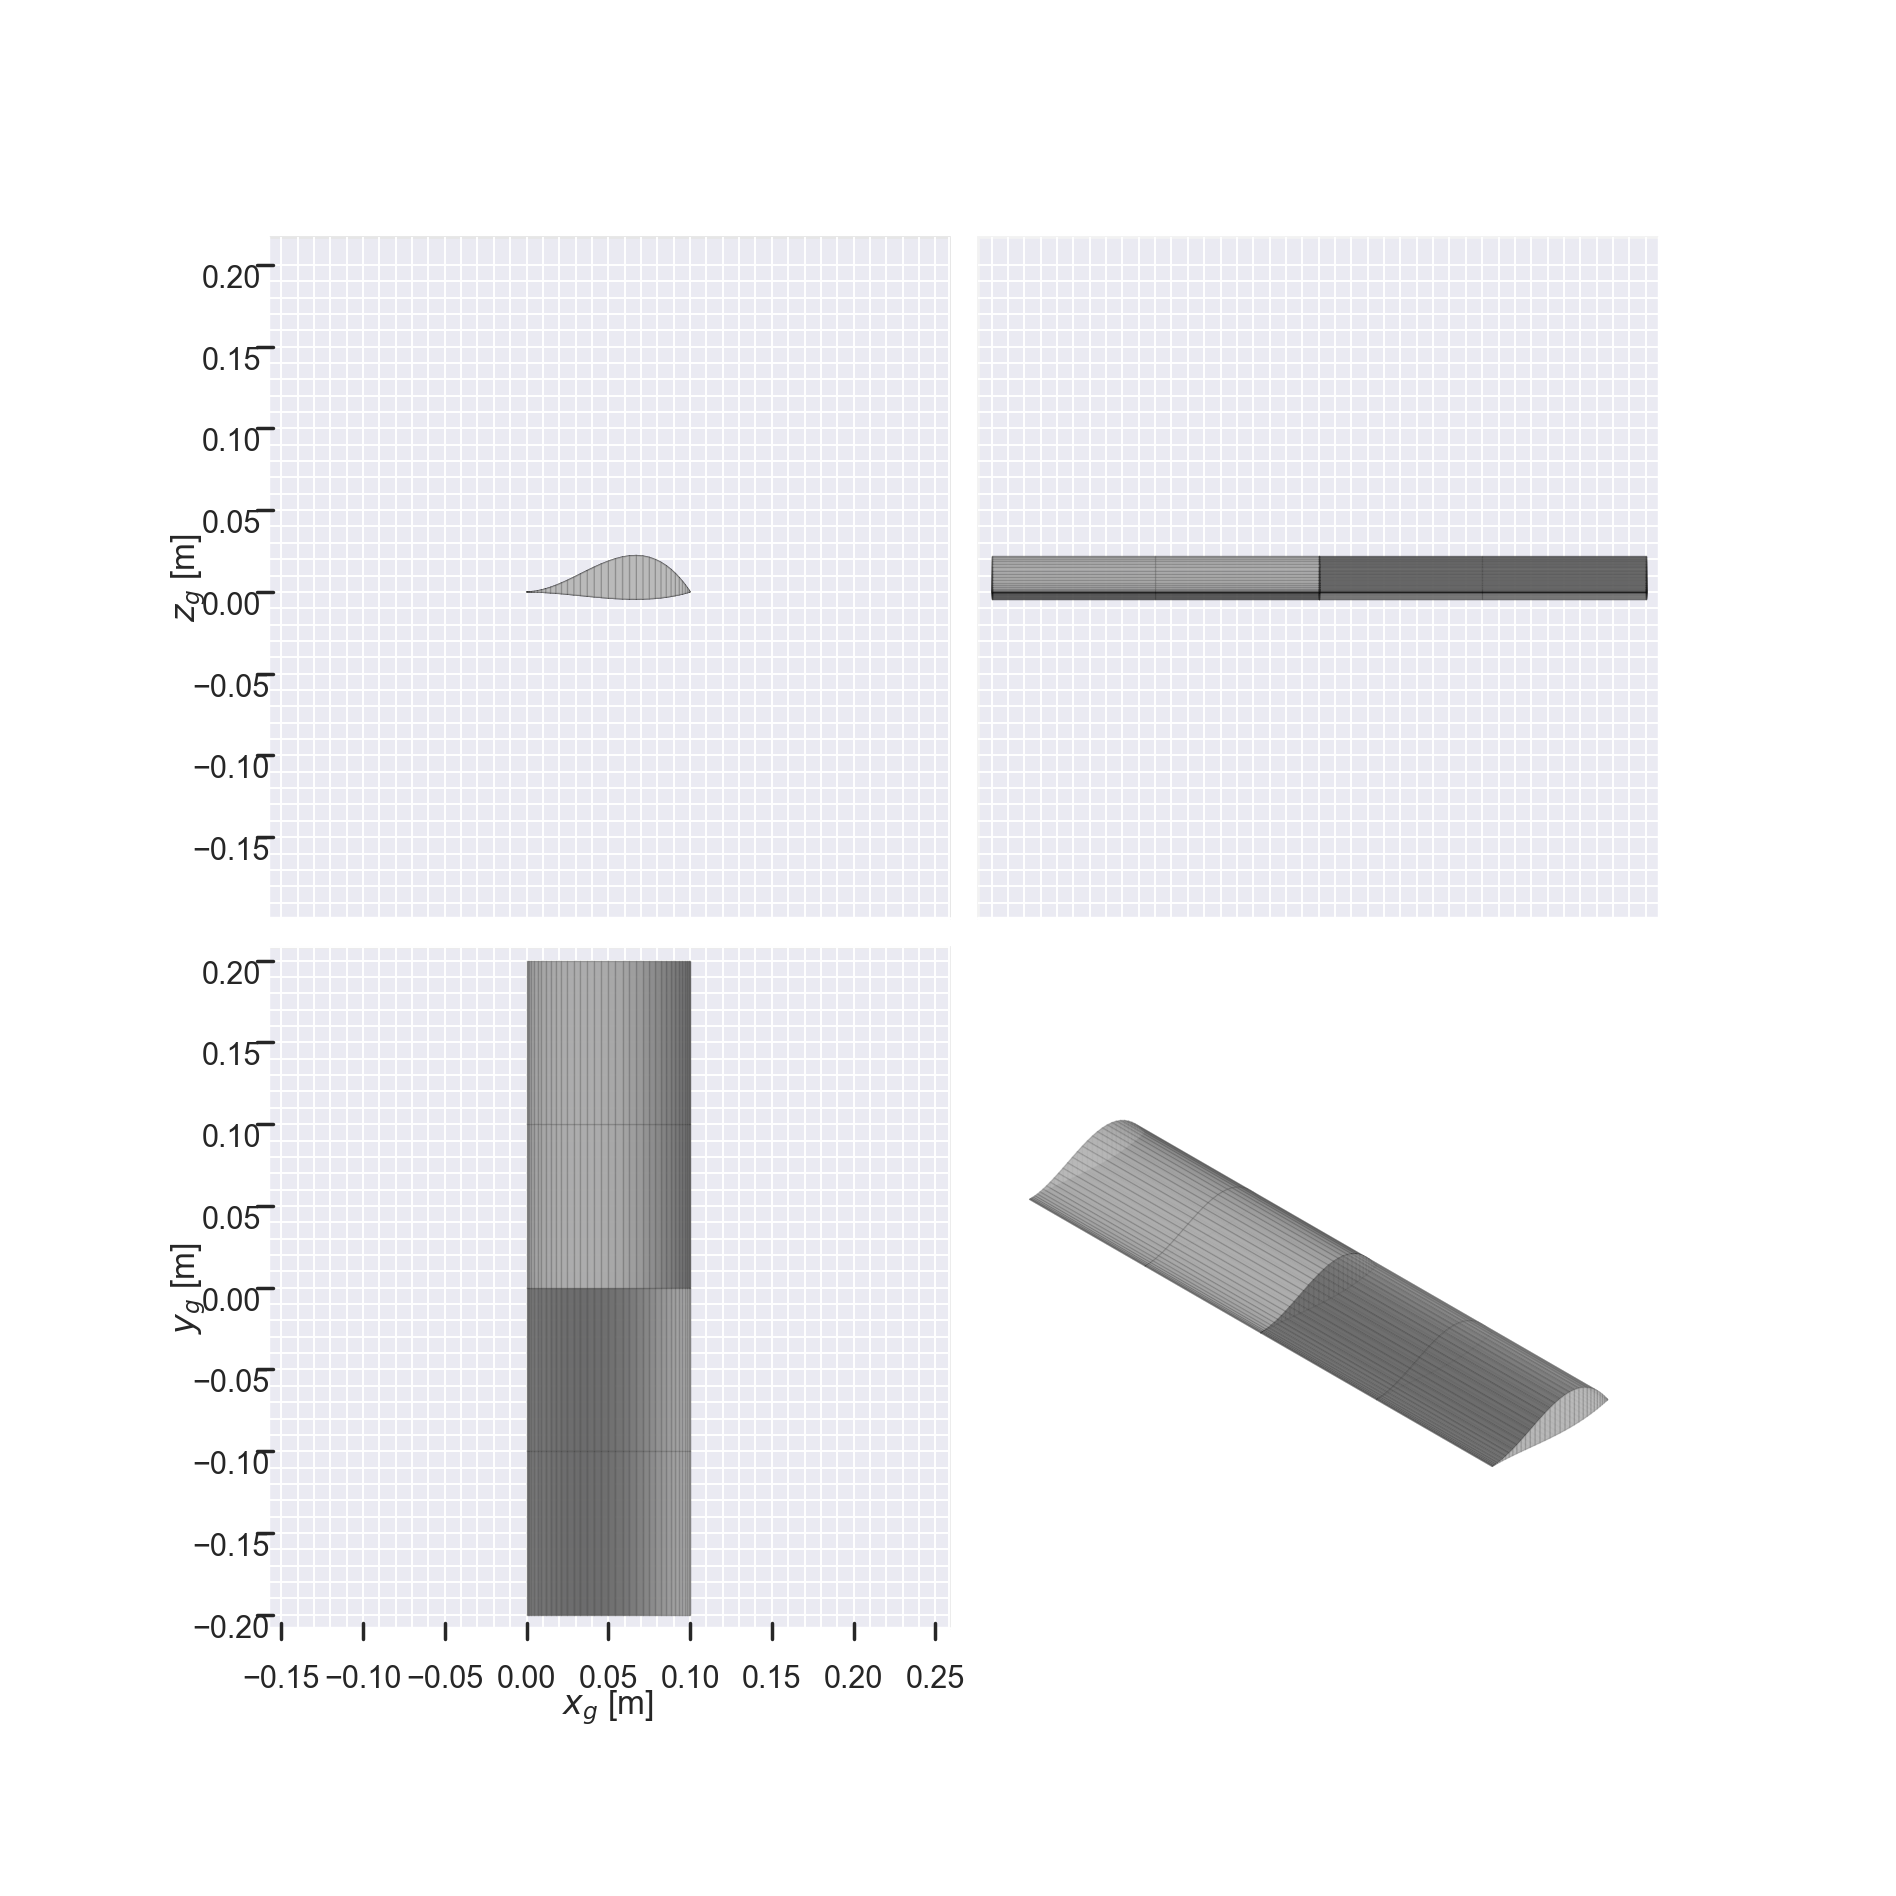

Output()

We lerned


In [5]:
from stable_baselines3 import PPO
import os
import time
from stable_baselines3.common.callbacks import EvalCallback
import copy

models_dir = f"models/A2C-{int(time.time())}"
logdir = f"logs/A2C-{int(time.time())}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

steps = 40 #steps per episode used in model training before resetting
env = AeroEnv(
    episodeSteps=steps,
    numChords=3, 
	initialYSpacing=0.1, 
	initialChordLength=0.1, 
	initialUpperKulfan=1.5, 
	initialLowerKulfan=-0.3, 
	initialLEW=0, 
	initialN1=2, 
	initialN2=1, 
    dX_bounds = (-0.02, 0.02),
	dY_bounds = (0.0, 0.2),
	dZ_bounds = (-0.02, 0.02),
	dChord_bounds = (0, 0.2),
	dTwist_bounds = (-0.5, 0.5),
	KT_bounds = (0, 1),
	KB_bounds = (-1, 0),
	N_bounds = (1, 3),
	LEW_bounds = (0, 0.2),
	kulfanWeightResolution = 5
)

evalEnv = copy.deepcopy(env)
eval_callback = EvalCallback(
    eval_env=evalEnv, 
    best_model_save_path='./logs/best_model/',
    log_path='./logs/eval_log/', 
    eval_freq=1000)

# TODO: find a way to use eval callback that doesnt add 10 minutes per eval to the run

env.reset()
env.render()

model = PPO(
	n_steps=steps,
    batch_size=steps,
	policy="MlpPolicy",
	env=env,
    learning_rate=.001,
	verbose=0,
    tensorboard_log=logdir,
)

total_timesteps = 600
model.learn(total_timesteps=total_timesteps, progress_bar=True)

print("We lerned")

{'F_g': array([ 3.25346270e+01, -1.31623878e-13, -1.49802696e+03]), 'F_b': (-32.534627009661975, -1.3162387846321622e-13, 1498.0269647574817), 'F_w': (-32.534627009661975, -1.3162387846321622e-13, 1498.0269647574817), 'M_g': array([ 2.44769829e-12, -9.44700543e+02, -5.67670910e-14]), 'M_b': (-2.4476982940502268e-12, -944.7005430315733, 5.6767091027865035e-14), 'M_w': (-2.4476982940502268e-12, -944.7005430315733, 5.6767091027865035e-14), 'L': -1498.0269647574817, 'D': 32.534627009661975, 'Y': -1.3162387846321622e-13, 'l_b': -2.4476982940502268e-12, 'm_b': -944.7005430315733, 'n_b': 5.6767091027865035e-14, 'CL': -1.5273133975049293, 'CD': 0.03317067908902893, 'CY': -1.3419712577802357e-16, 'Cl': -7.693927363792295e-17, 'Cm': -9.631694421708156, 'Cn': 1.784377903452575e-18}


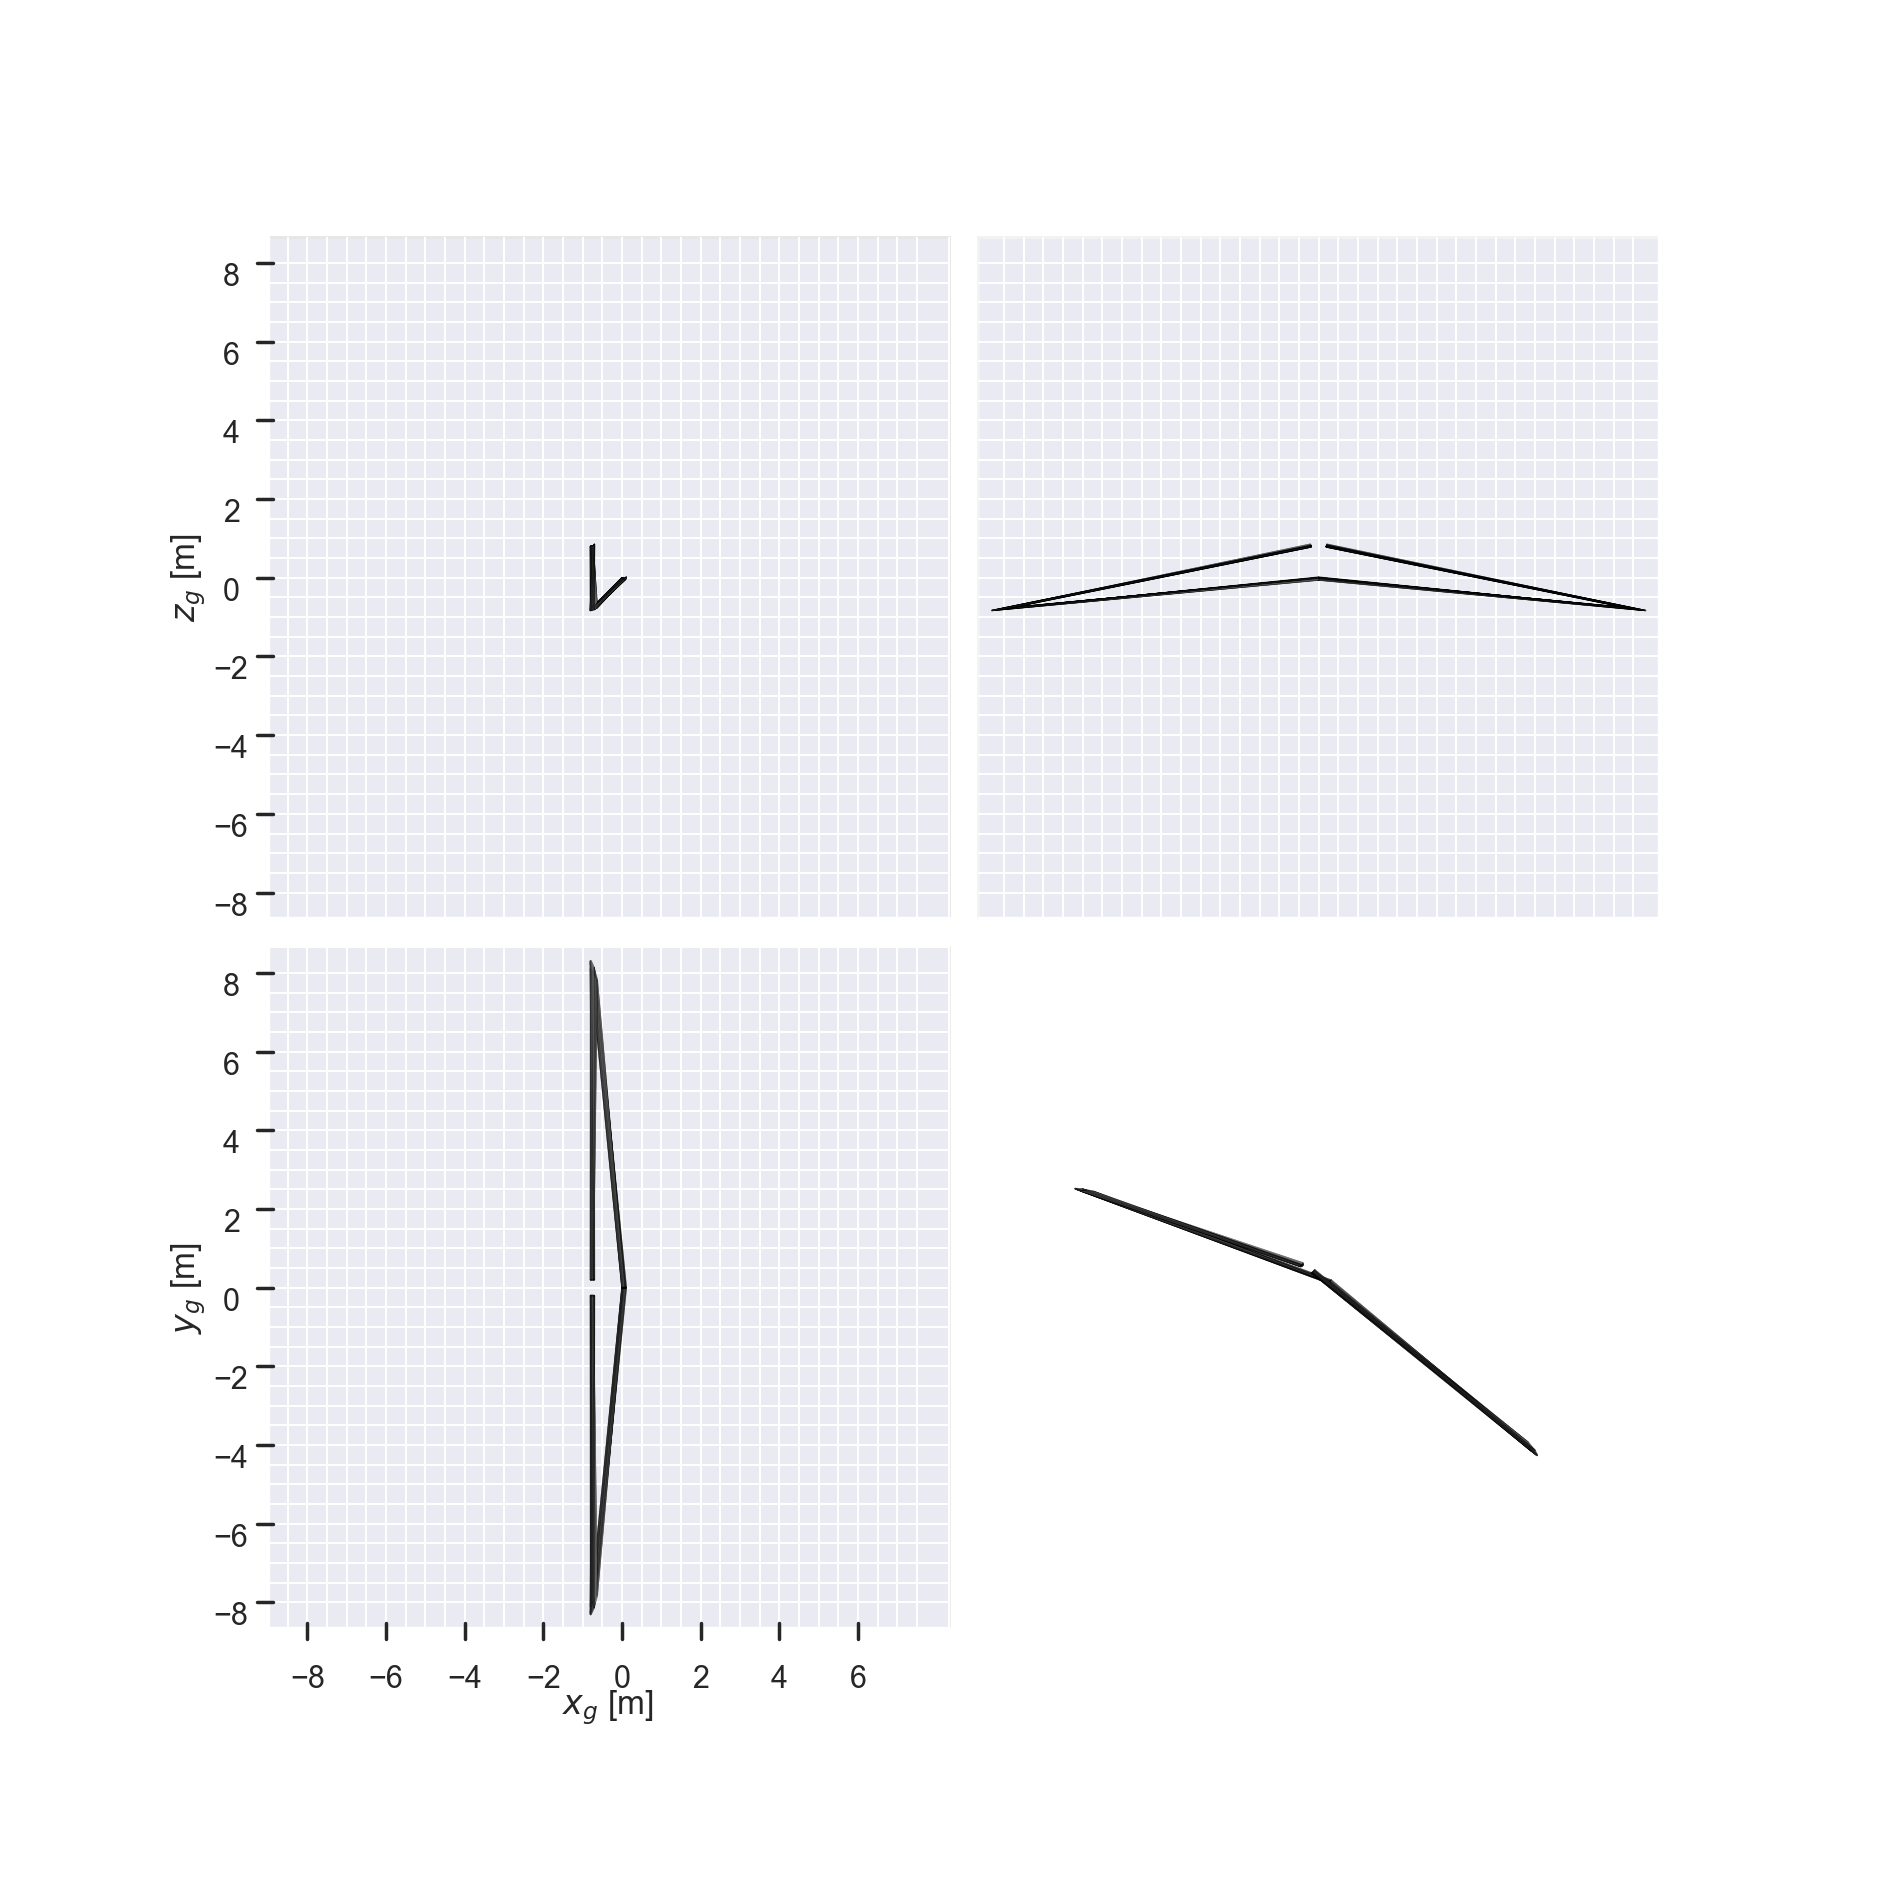

{'F_g': array([ 5.14472557e+11,  1.43240641e-02, -5.35234458e+11]), 'F_b': (-514472556801.18445, 0.014324064108534151, 535234457853.25665), 'F_w': (-514472556801.18445, 0.014324064108534151, 535234457853.25665), 'M_g': array([-6.03016814e-02,  1.01315905e+12, -1.80705491e-02]), 'M_b': (0.06030168142930936, 1013159049095.2136, 0.018070549104969746), 'M_w': (0.06030168142930936, 1013159049095.2136, 0.018070549104969746), 'L': -535234457853.25665, 'D': 514472556801.18445, 'Y': 0.014324064108534151, 'l_b': 0.06030168142930936, 'm_b': 1013159049095.2136, 'n_b': 0.018070549104969746, 'CL': -18923697.405010782, 'CD': 18189641.651877813, 'CY': 5.064402166614477e-07, 'Cl': 1.0237608976774036e-07, 'Cm': 5947152.287049914, 'Cn': 3.067894813996949e-08}


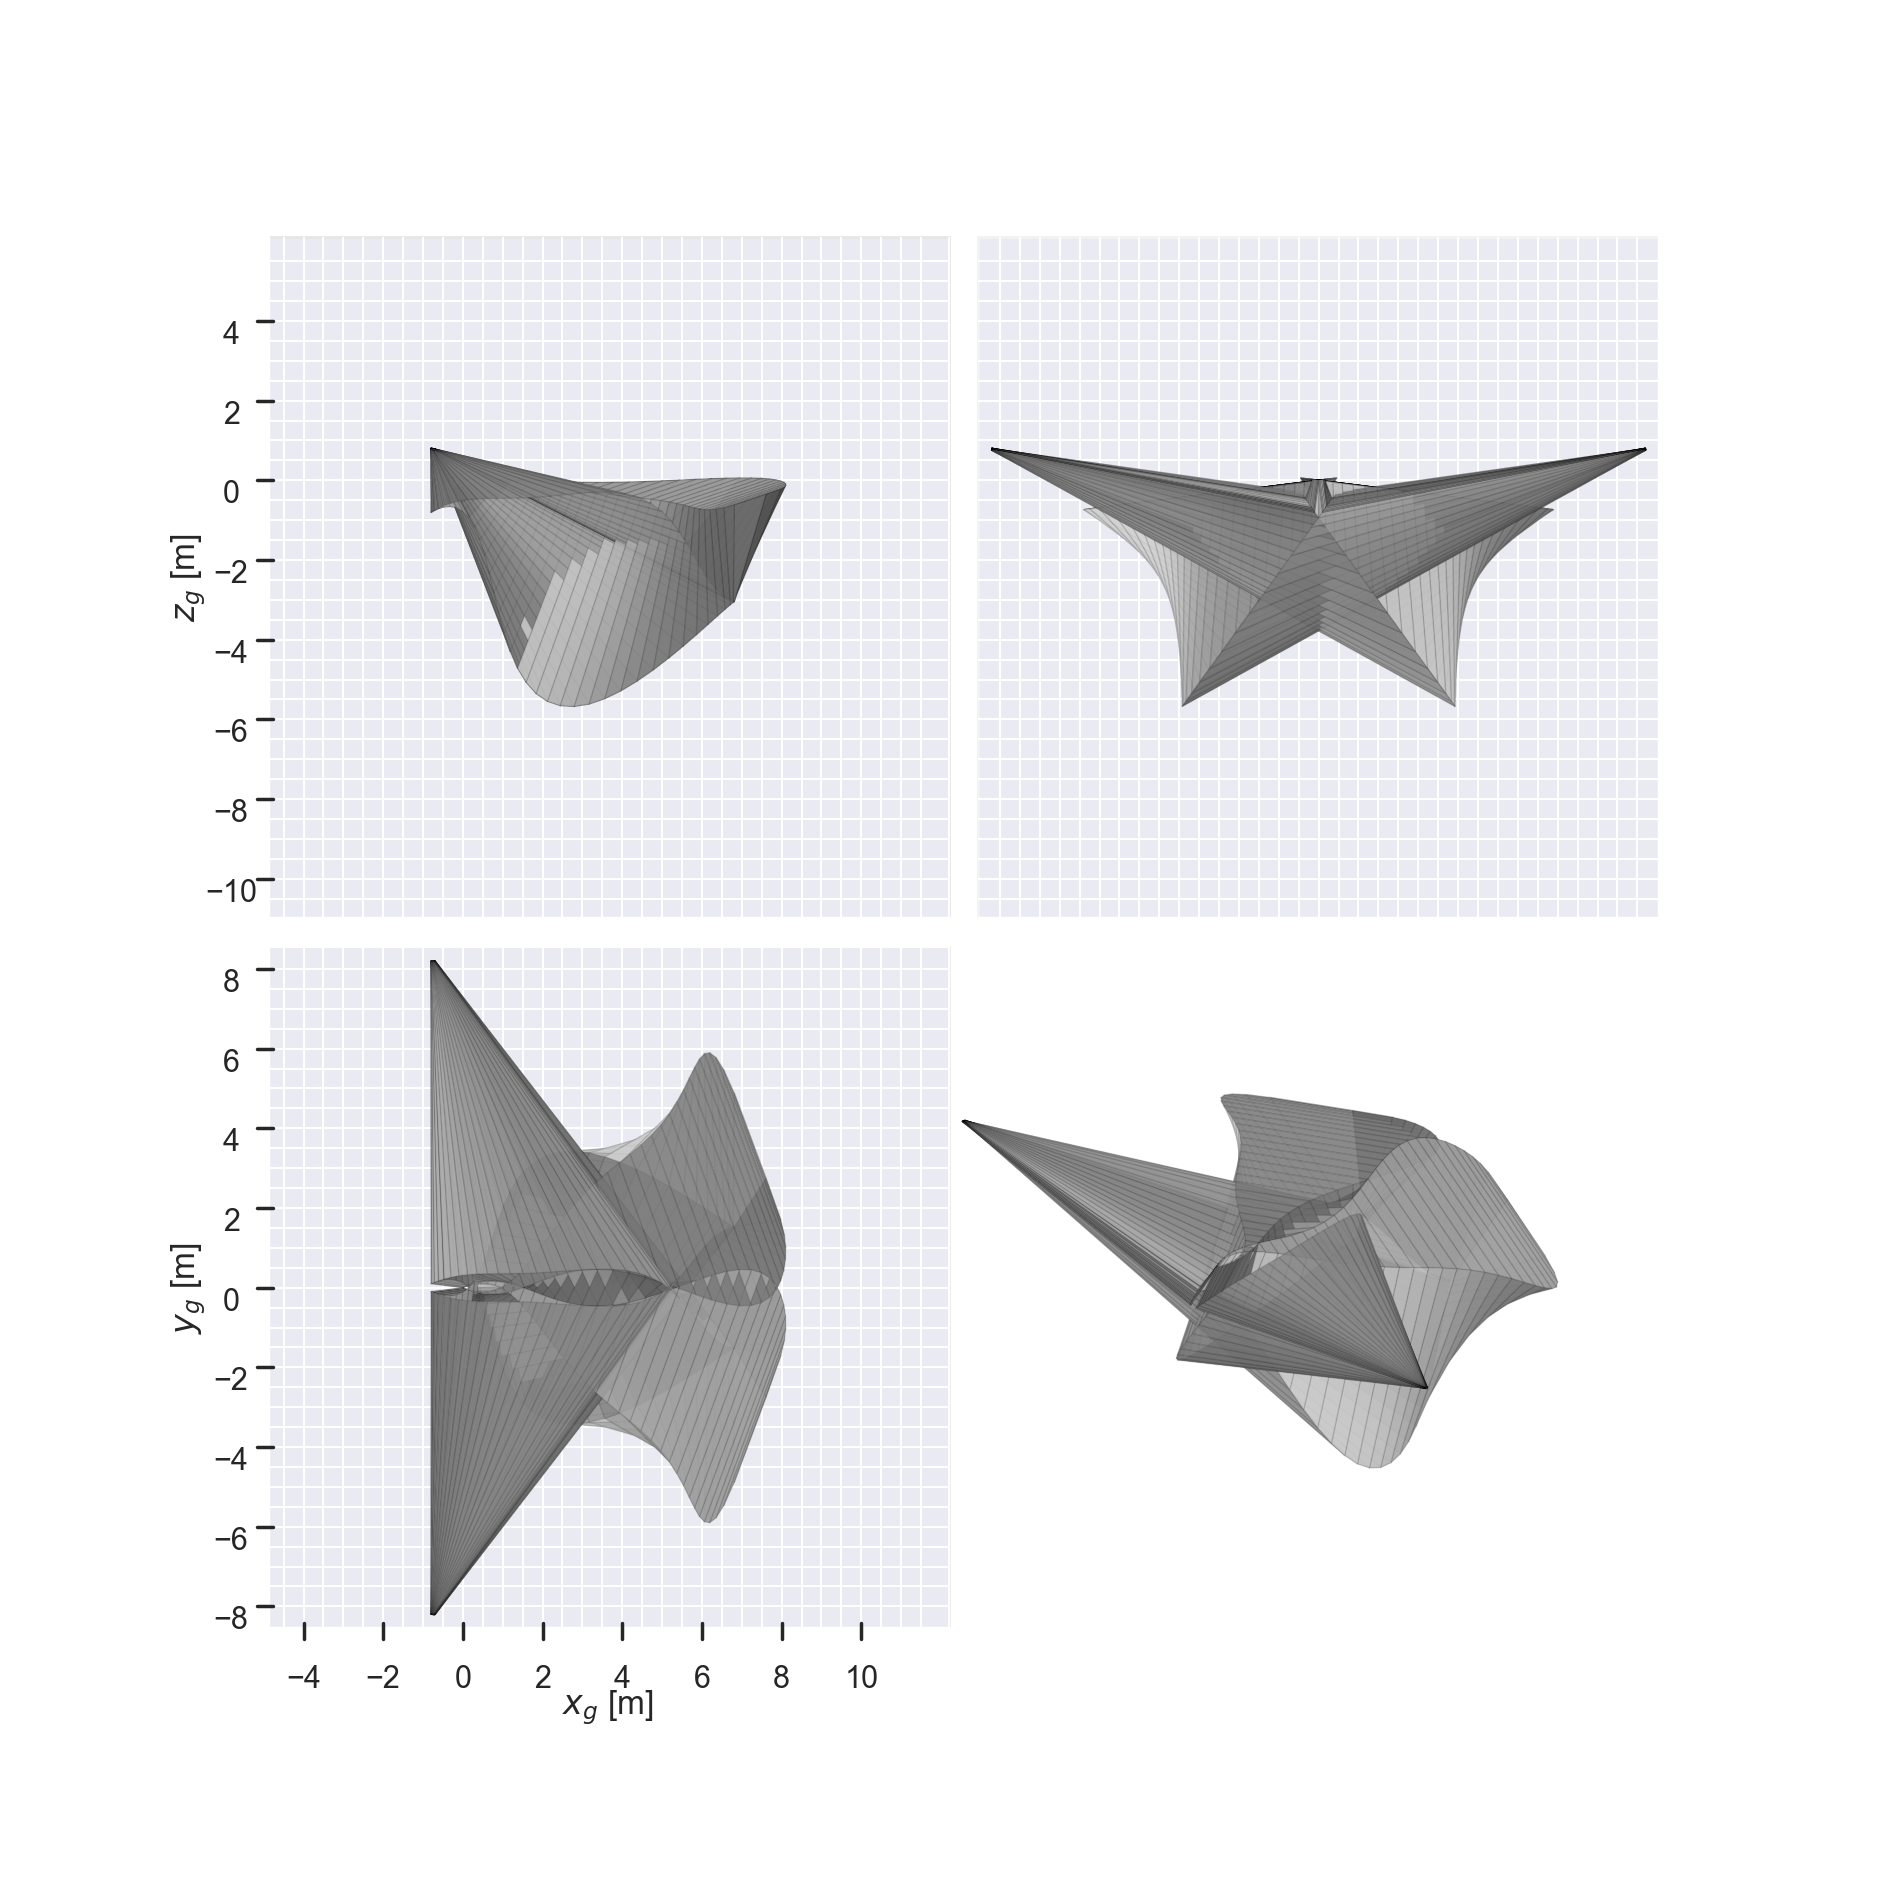

{'F_g': array([ 4.46371719e+08,  1.41626701e-03, -9.98264479e+08]), 'F_b': (-446371719.24482447, 0.0014162670137380928, 998264478.5034534), 'F_w': (-446371719.24482447, 0.0014162670137380928, 998264478.5034534), 'M_g': array([-9.86553273e-03, -1.08861700e+09, -5.55406609e-03]), 'M_b': (0.009865532727943105, -1088617003.407321, 0.005554066088848231), 'M_w': (0.009865532727943105, -1088617003.407321, 0.005554066088848231), 'L': -998264478.5034534, 'D': 446371719.24482447, 'Y': 0.0014162670137380928, 'l_b': 0.009865532727943105, 'm_b': -1088617003.407321, 'n_b': 0.005554066088848231, 'CL': -24763.754190302443, 'CD': 11073.057061444151, 'CY': 3.513306238104564e-08, 'Cl': 7.498475885339191e-09, 'Cm': -5000.193747476686, 'Cn': 4.221467991773794e-09}


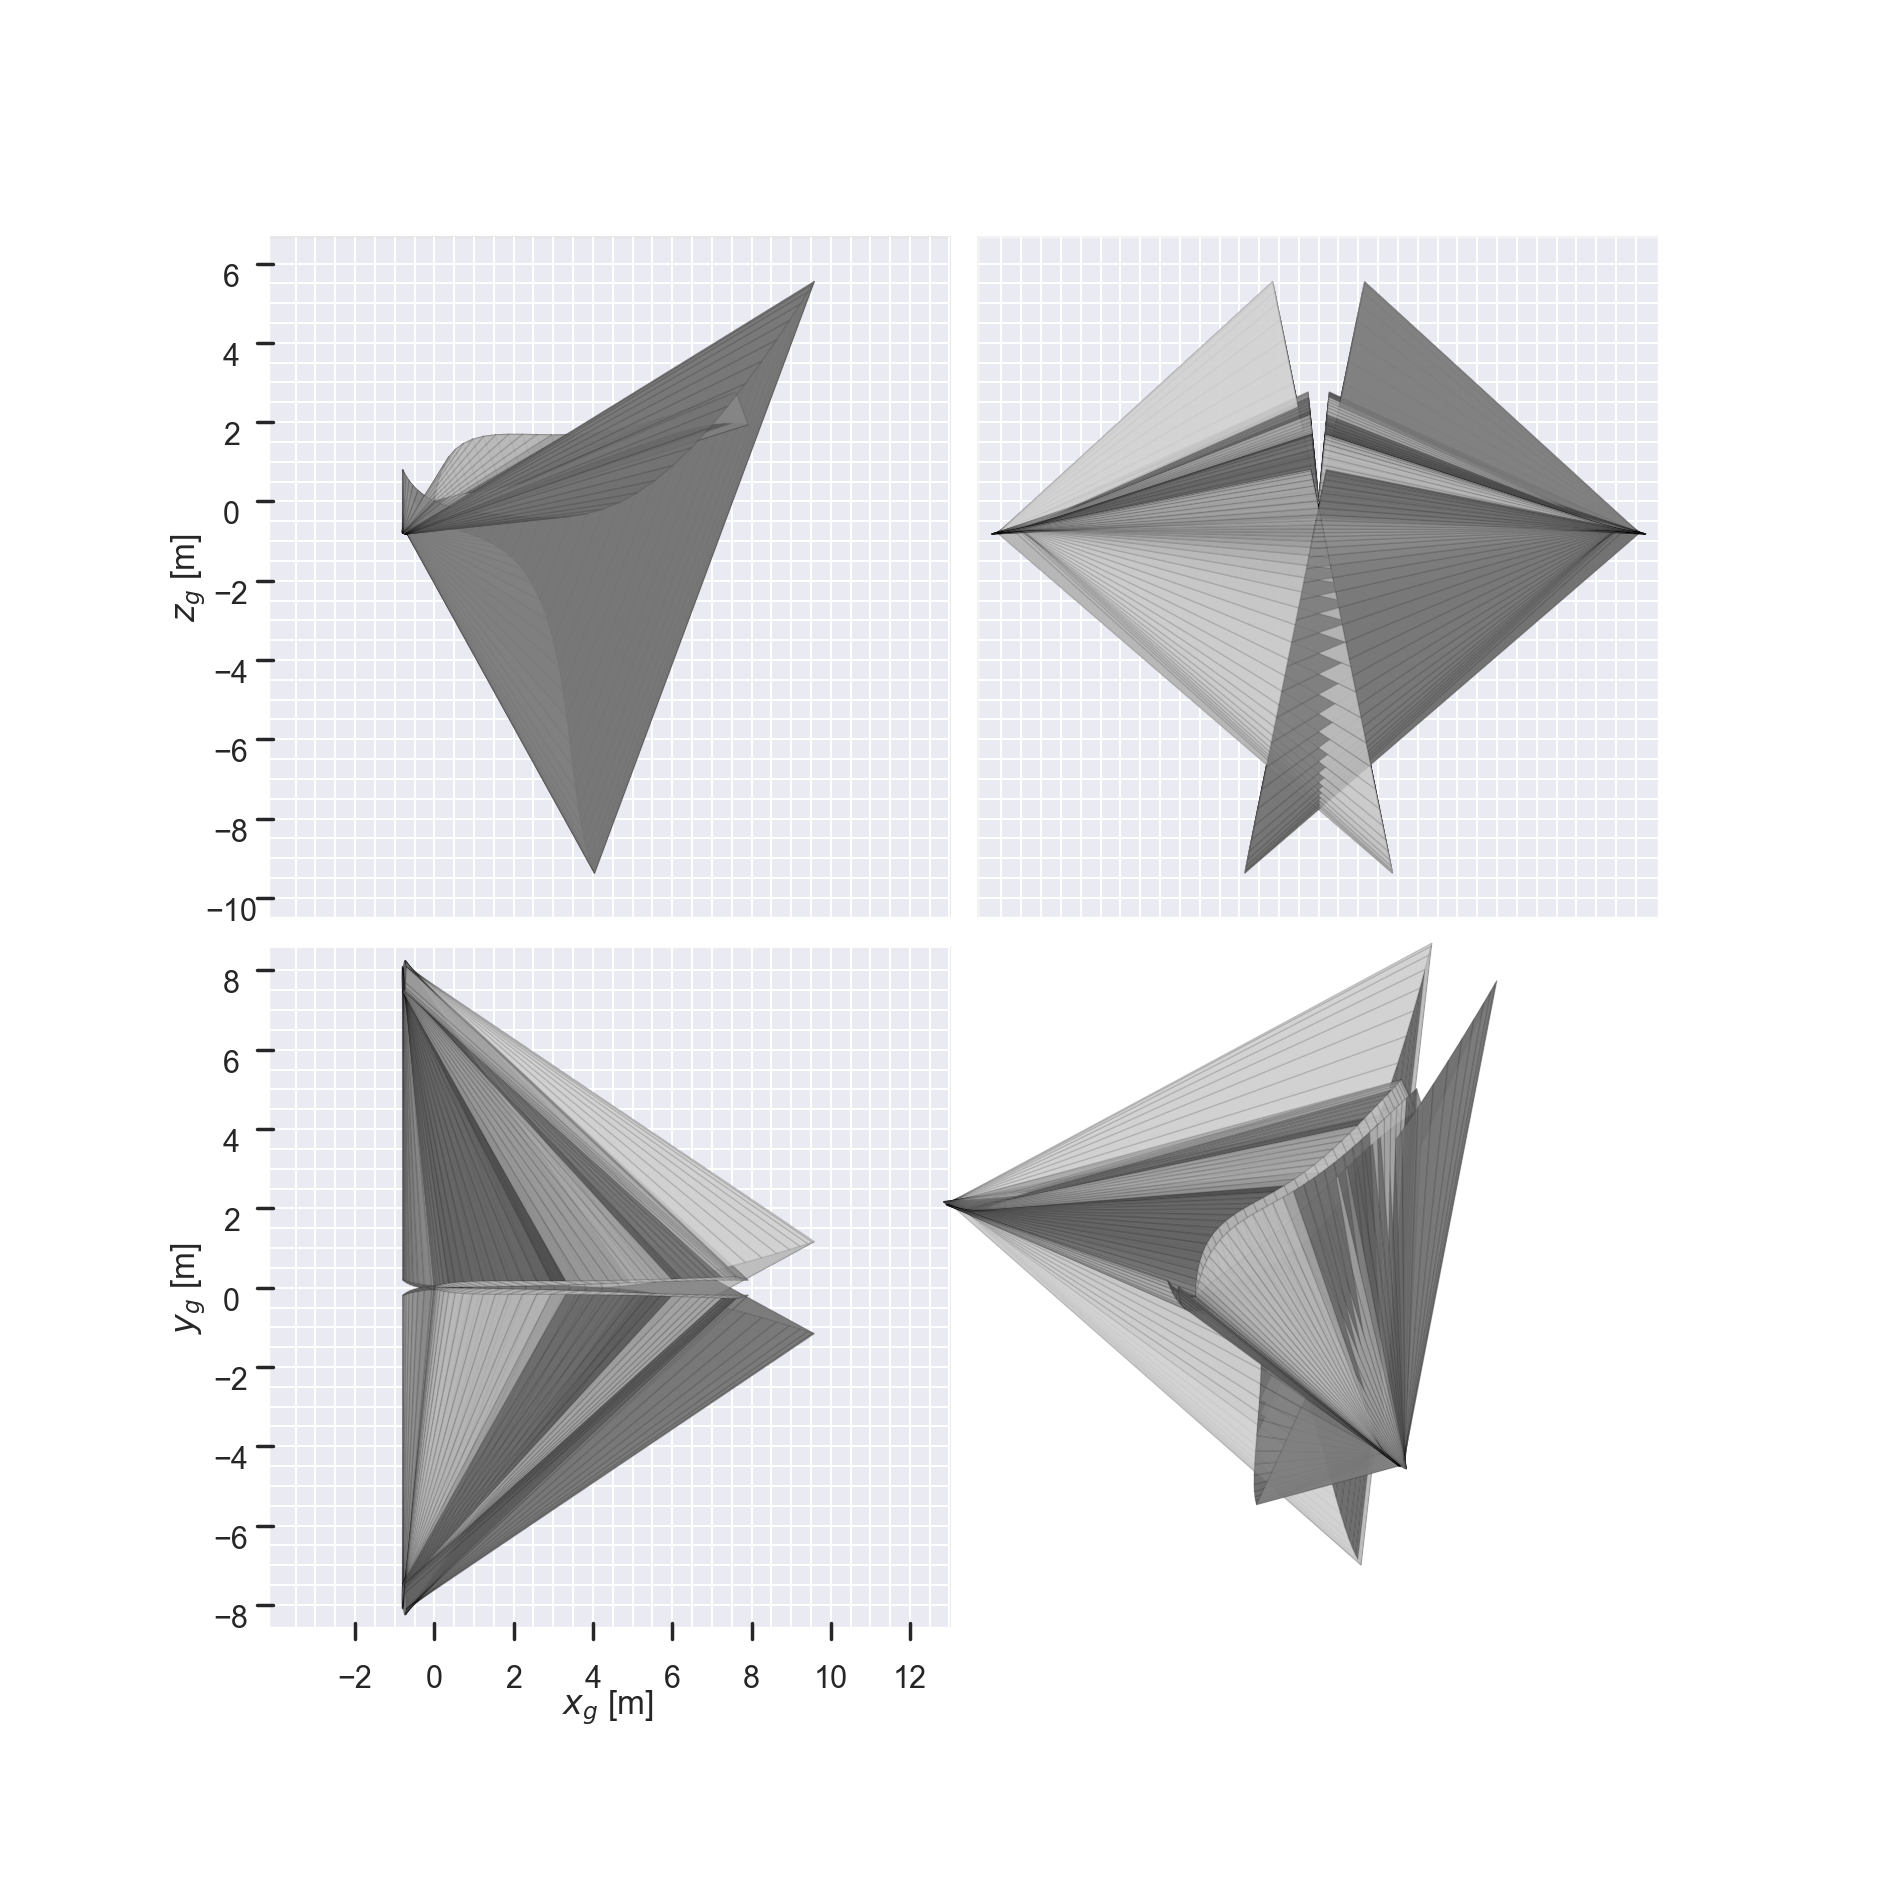

{'F_g': array([ 5.84838837e+05,  8.76715447e-08, -9.85741020e+05]), 'F_b': (-584838.8366204613, 8.767154469069283e-08, 985741.0204815213), 'F_w': (-584838.8366204613, 8.767154469069283e-08, 985741.0204815213), 'M_g': array([-2.12155555e-08,  4.77514238e+06,  3.95715460e-07]), 'M_b': (2.1215555534581654e-08, 4775142.383648346, -3.95715460399515e-07), 'M_w': (2.1215555534581654e-08, 4775142.383648346, -3.95715460399515e-07), 'L': -985741.0204815213, 'D': 584838.8366204613, 'Y': 8.767154469069283e-08, 'l_b': 2.1215555534581654e-08, 'm_b': 4775142.383648346, 'n_b': -3.95715460399515e-07, 'CL': -36.25424330800696, 'CD': 21.50959434401199, 'CY': 3.2244427759053245e-12, 'Cl': 4.223847184343005e-14, 'Cm': 31.44875687984505, 'Cn': -7.878377874597787e-13}


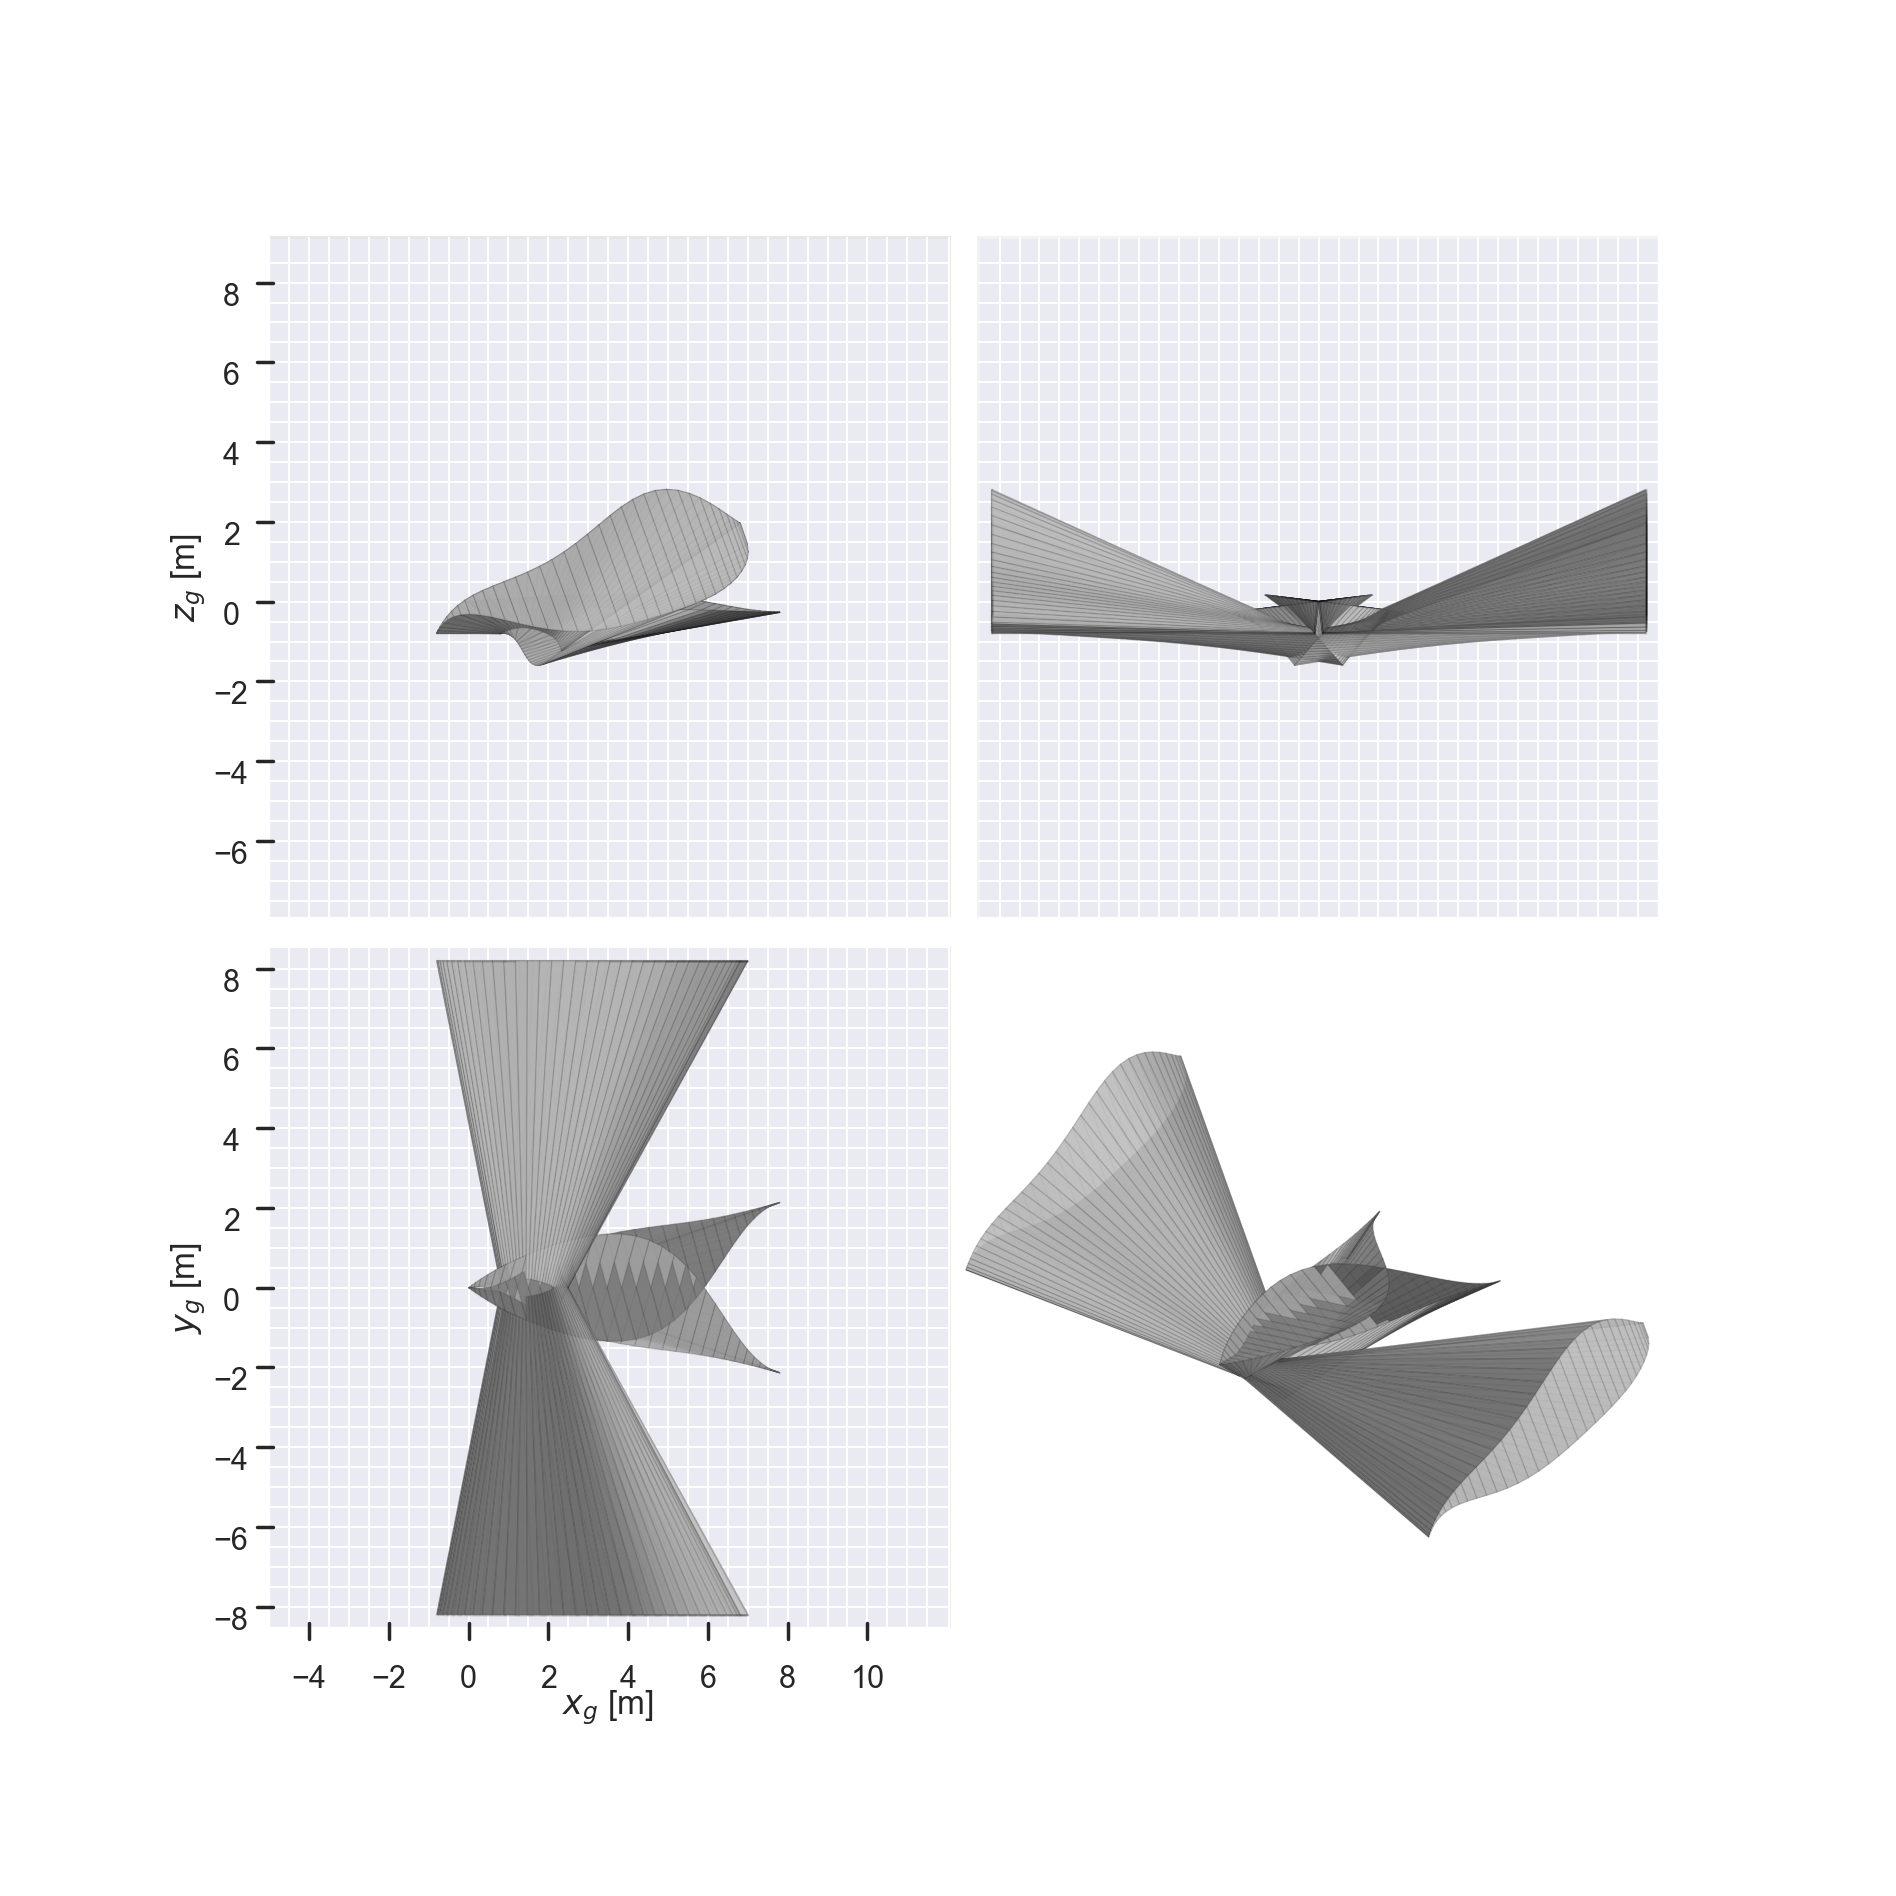

{'F_g': array([ 5.96044450e+01,  4.66293670e-15, -1.13740539e+02]), 'F_b': (-59.60444499600133, 4.6629367034256575e-15, 113.74053851042363), 'F_w': (-59.60444499600133, 4.6629367034256575e-15, 113.74053851042363), 'M_g': array([-7.50583623e-13,  3.56320603e+02,  7.46069873e-14]), 'M_b': (7.505836230325968e-13, 356.3206033271055, -7.460698725481052e-14), 'M_w': (7.505836230325968e-13, 356.3206033271055, -7.460698725481052e-14), 'L': -113.74053851042363, 'D': 59.60444499600133, 'Y': 4.6629367034256575e-15, 'l_b': 7.505836230325968e-13, 'm_b': 356.3206033271055, 'n_b': -7.460698725481052e-14, 'CL': -0.18645828583024432, 'CD': 0.09771135944462742, 'CY': 7.644092388185759e-18, 'Cl': 6.099122893270041e-17, 'Cm': 5.841270823267803, 'Cn': -6.062444876231458e-18}


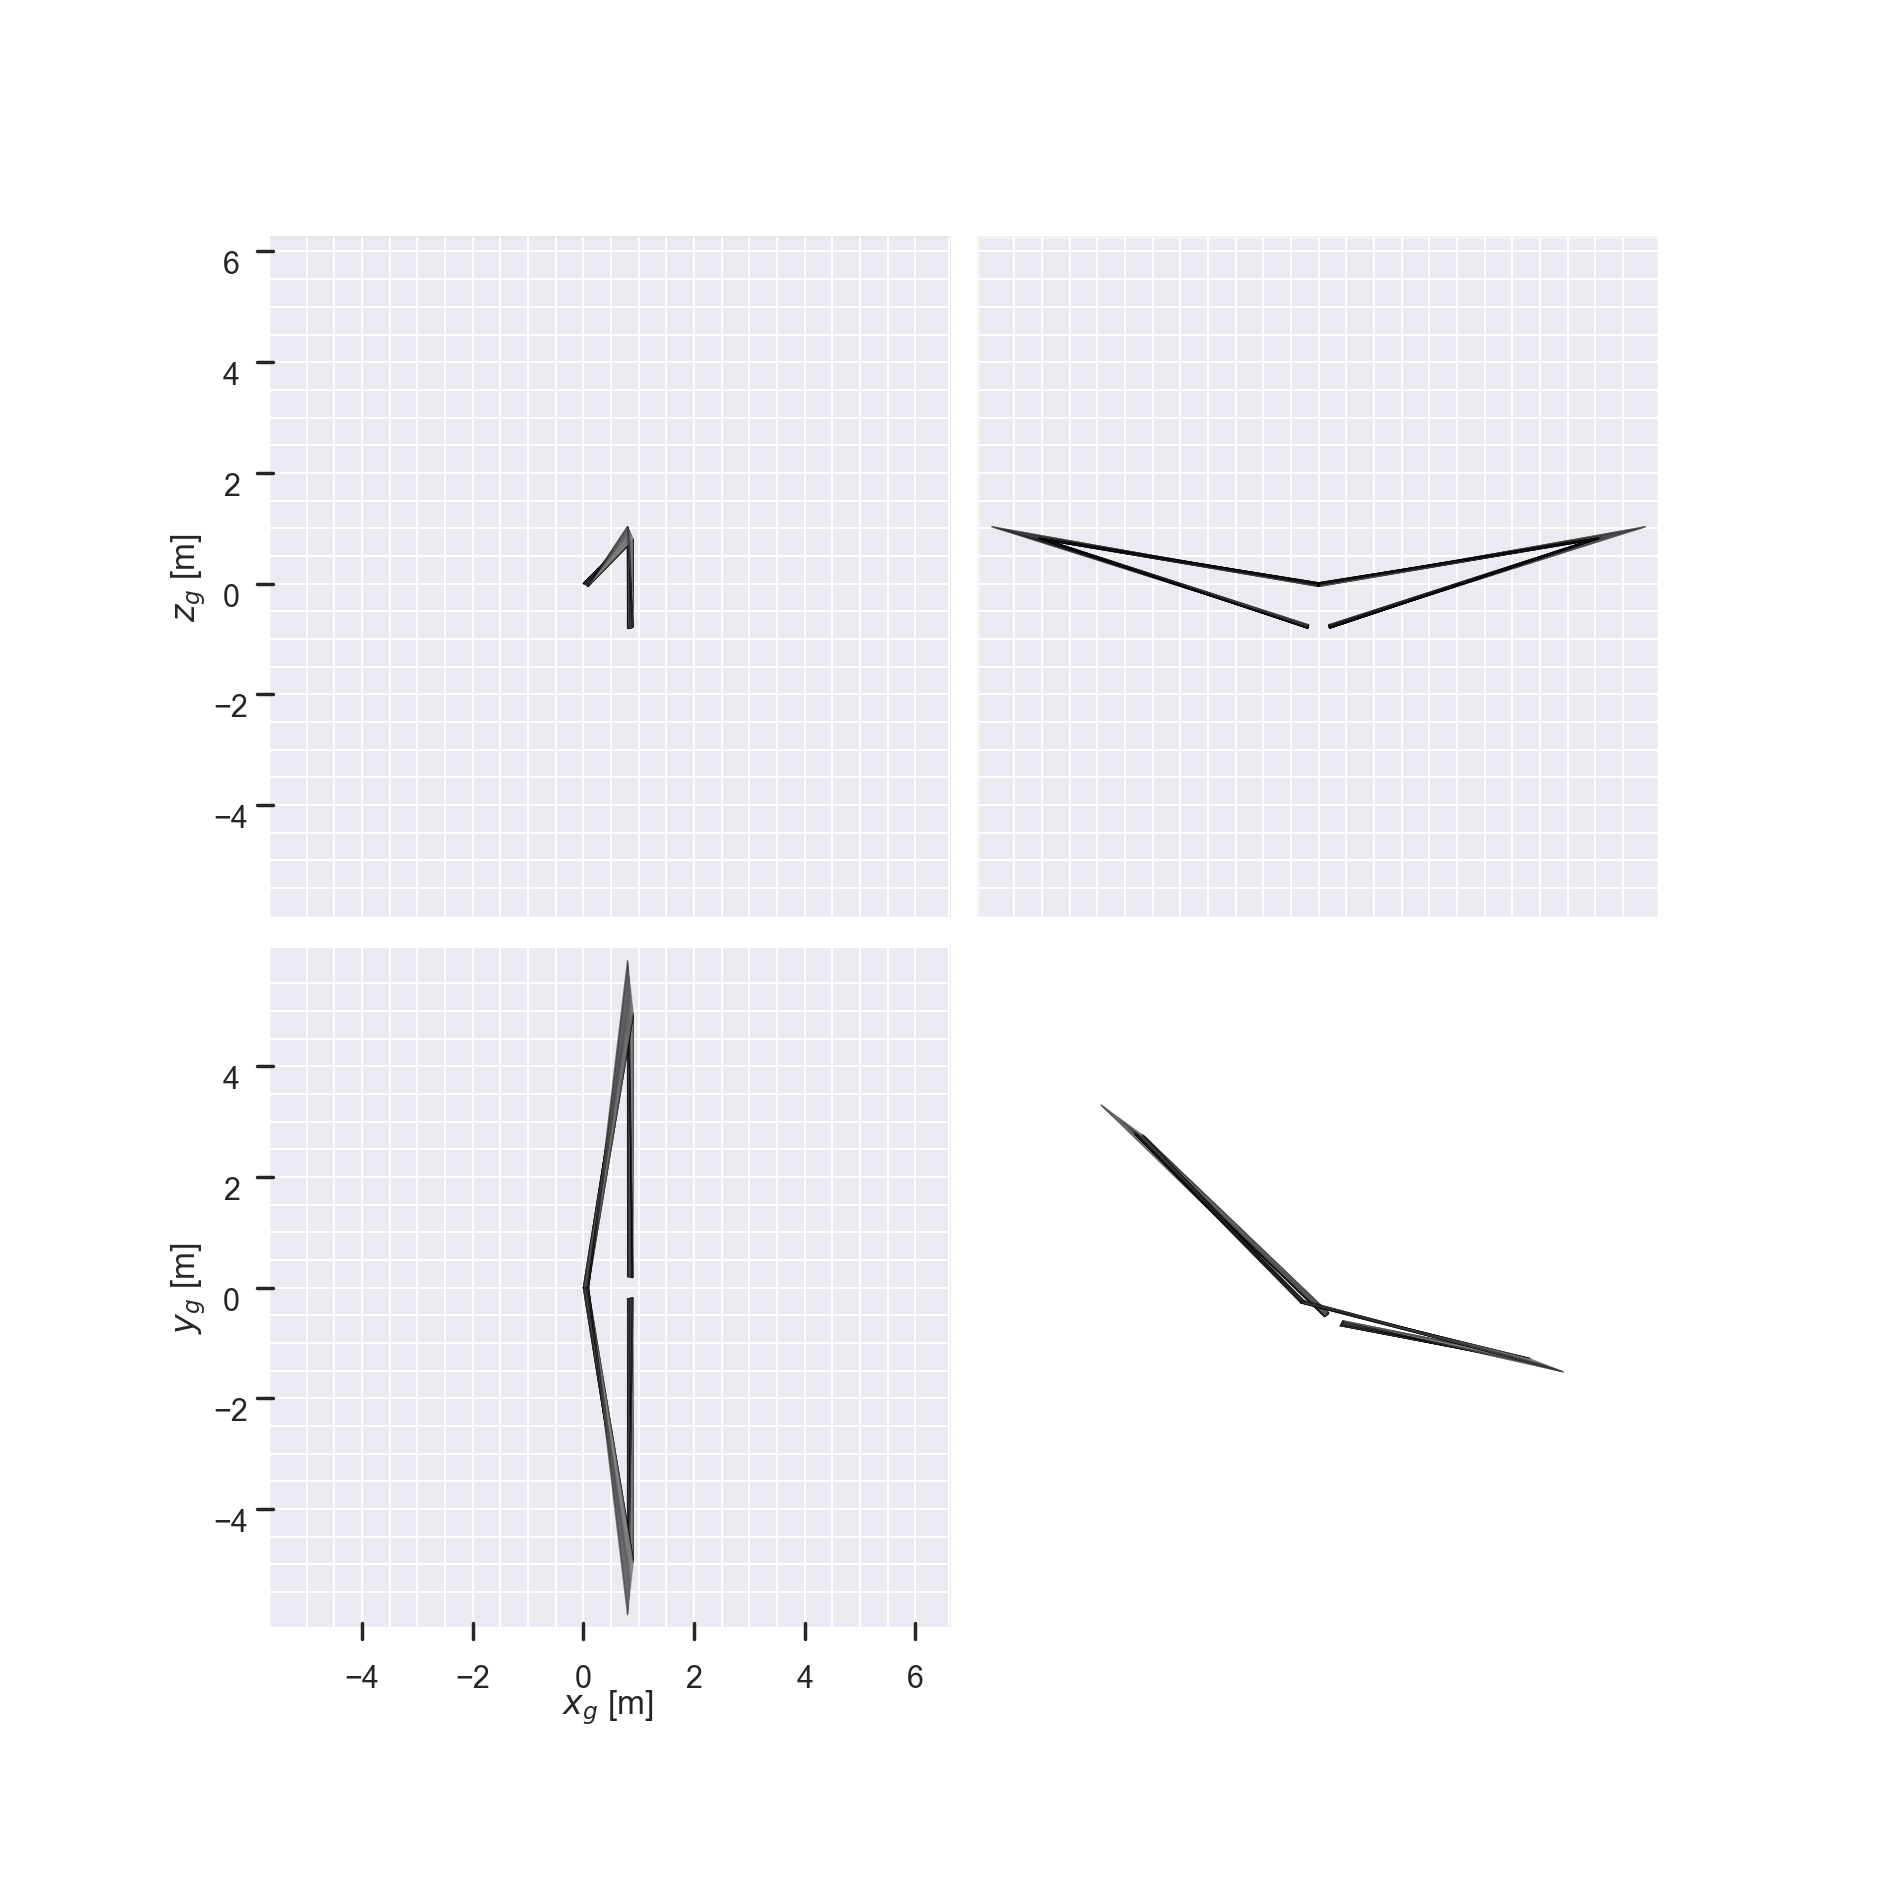

{'F_g': array([ 4.12879398e+01, -7.31794047e-14, -1.26058761e+03]), 'F_b': (-41.28793984785258, -7.31794047017717e-14, 1260.5876136757531), 'F_w': (-41.28793984785258, -7.31794047017717e-14, 1260.5876136757531), 'M_g': array([ 1.14939904e-11,  5.96391964e+02, -5.35514151e-14]), 'M_b': (-1.1493990438246615e-11, 596.3919641163722, 5.355141514690881e-14), 'M_w': (-1.1493990438246615e-11, 596.3919641163722, 5.355141514690881e-14), 'L': -1260.5876136757531, 'D': 41.28793984785258, 'Y': -7.31794047017717e-14, 'l_b': -1.1493990438246615e-11, 'm_b': 596.3919641163722, 'n_b': 5.355141514690881e-14, 'CL': -2.528904339497902, 'CD': 0.08282903077692763, 'CY': -1.4680749842730525e-16, 'Cl': -1.3988626301372327e-15, 'Cm': 11.96440620019857, 'Cn': 6.5174121940024185e-18}


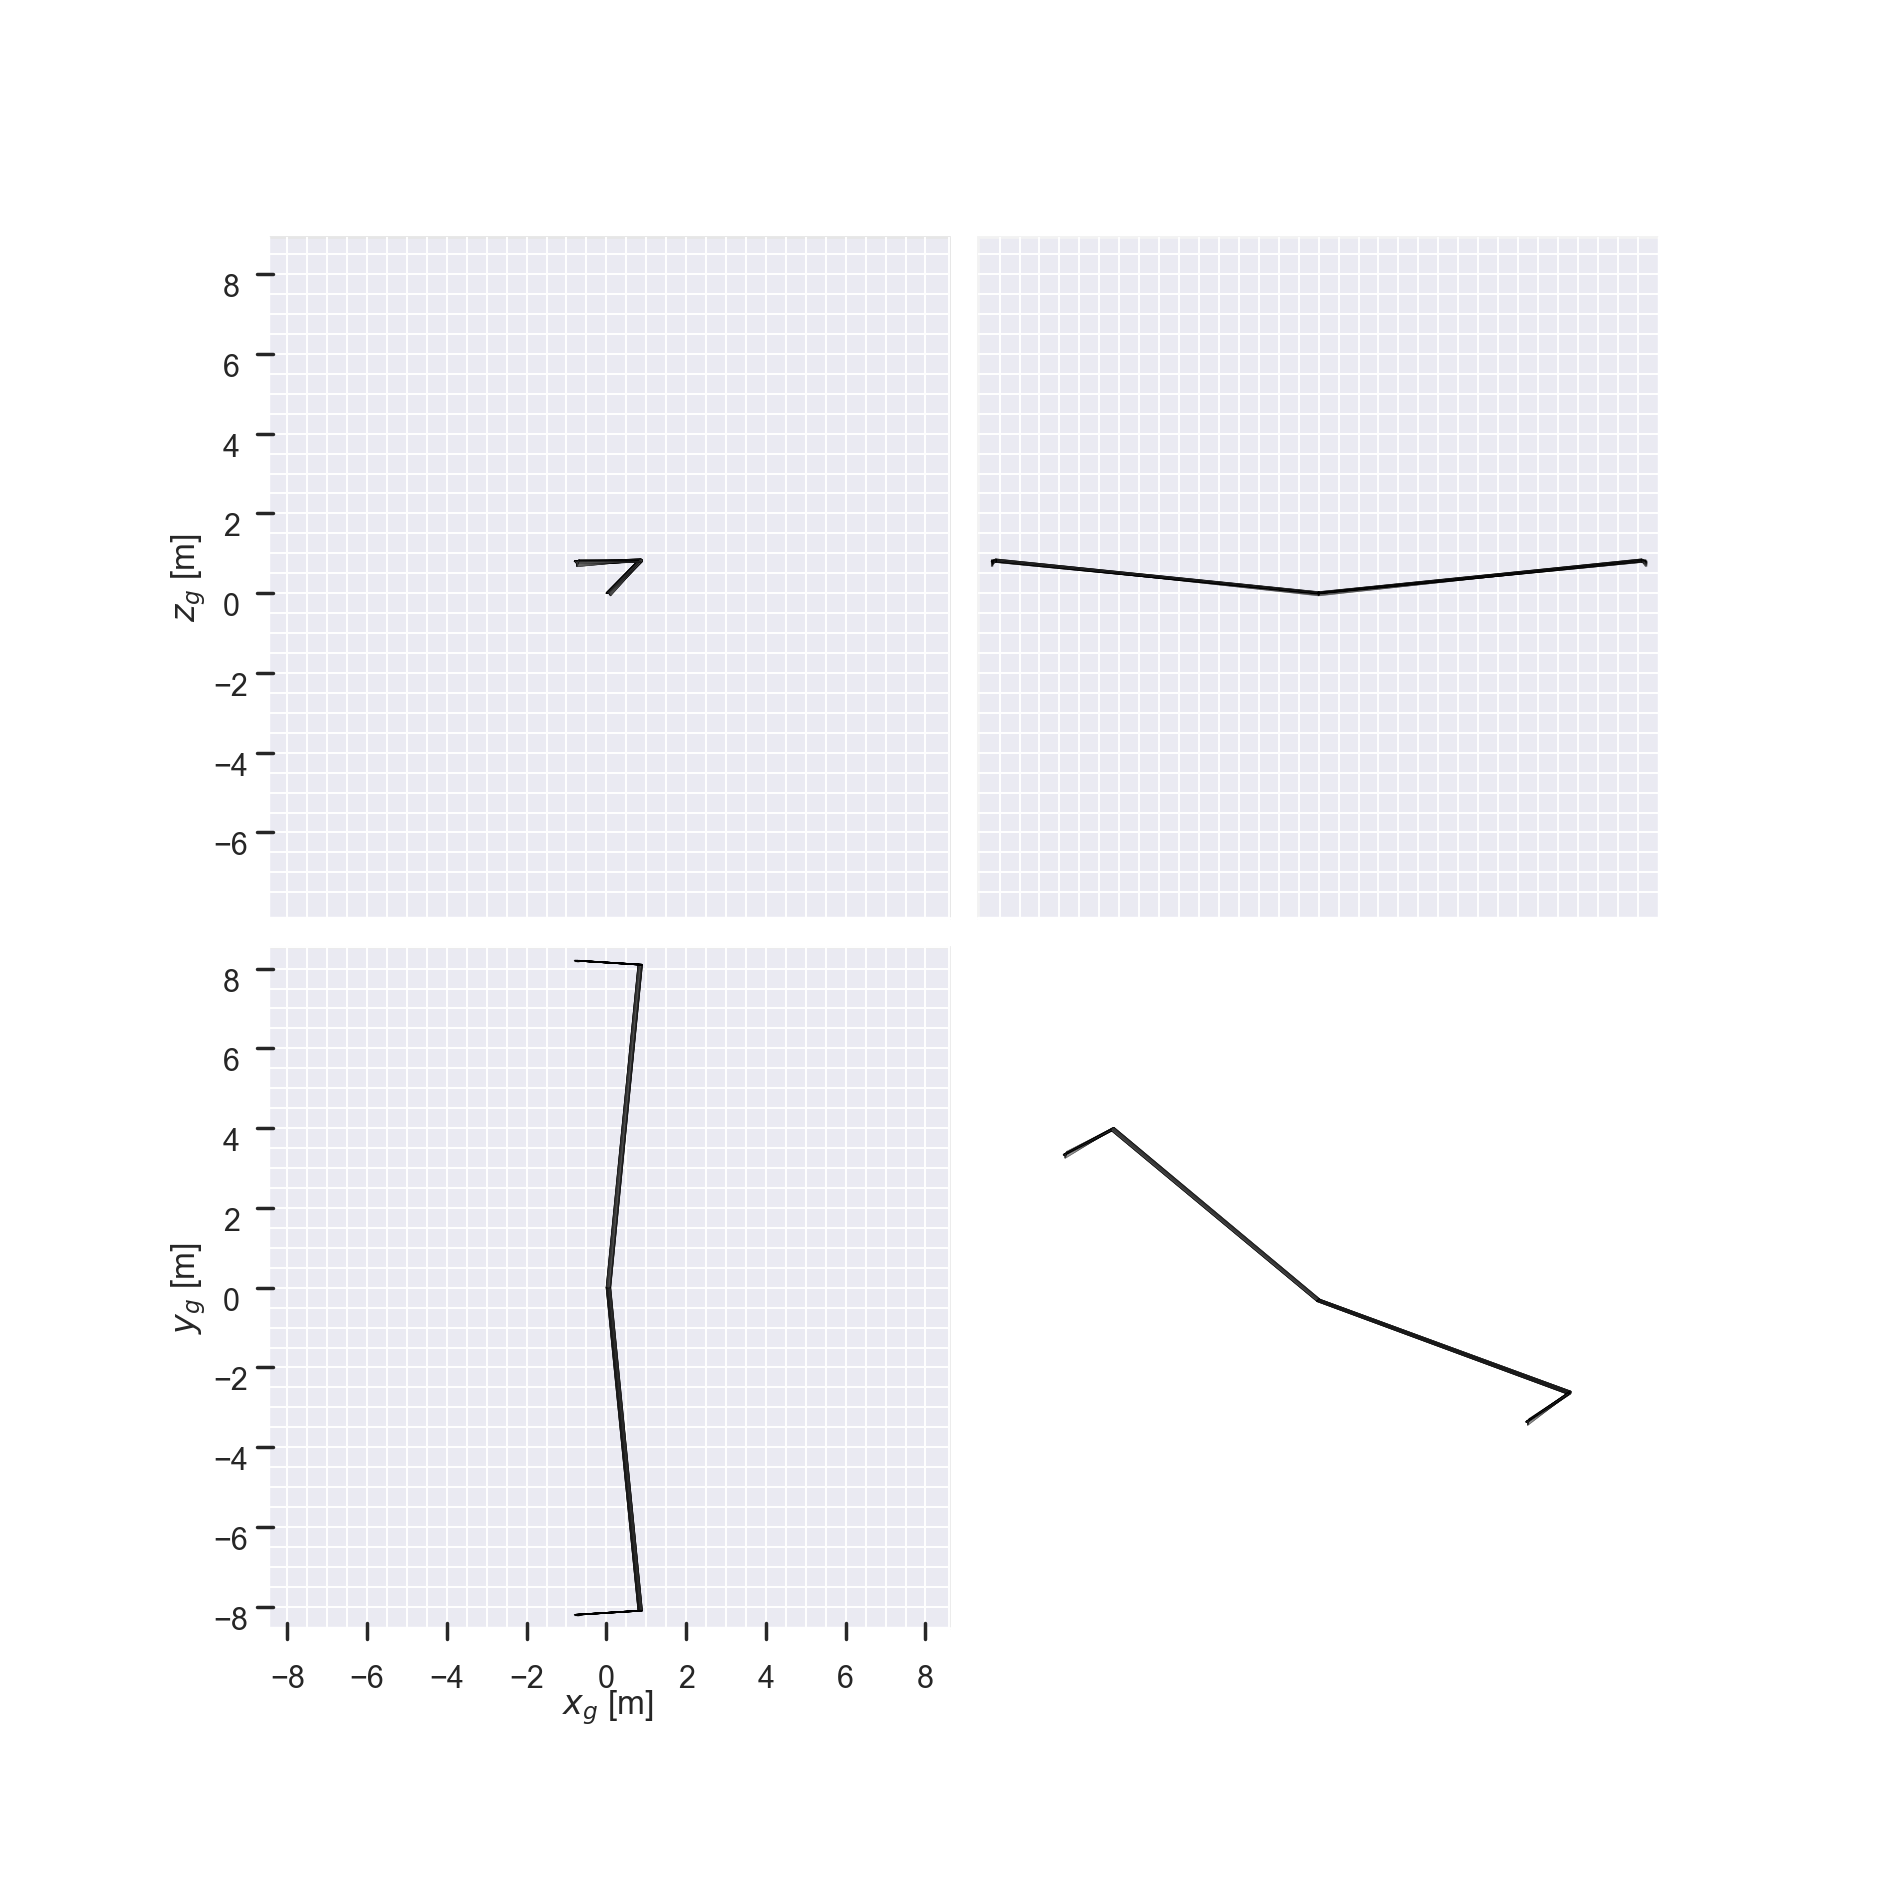

KeyboardInterrupt: 

In [6]:
num_episodes = 10
for _ in range(num_episodes):
    obs, info = env.reset()
    terminated = False
    action, nextHiddenState = model.predict(obs)
    for i in range(0,40):
        obs, rewards, terminated, truncated, info = env.step(action)
    env.render()
    env.reset()
env.close()